<a href="https://colab.research.google.com/github/jnoms/ESCC_microbiome/blob/main/collab/Figure3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Downloading data

In [48]:
# Data
! wget https://zenodo.org/record/4750577/files/2021-05-11_ESCC_MICROBIOME_UPLOAD.zip?download=1
! mv  2021-05-11_ESCC_MICROBIOME_UPLOAD.zip?download=1 package.zip
! unzip package.zip
! mv 2021-05-11_ESCC_MICROBIOME_UPLOAD/data data
! mv 2021-05-11_ESCC_MICROBIOME_UPLOAD/functions.r functions.r

--2021-05-12 19:43:15--  https://zenodo.org/record/4750577/files/2021-05-11_ESCC_MICROBIOME_UPLOAD.zip?download=1
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 104334449 (100M) [application/octet-stream]
Saving to: ‘2021-05-11_ESCC_MICROBIOME_UPLOAD.zip?download=1’

2021-05-11_ESCC_MIC 100%[===================>]  99.50M  24.9MB/s    in 4.5s    

2021-05-12 19:43:21 (21.9 MB/s) - ‘2021-05-11_ESCC_MICROBIOME_UPLOAD.zip?download=1’ saved [104334449/104334449]

Archive:  package.zip
replace 2021-05-11_ESCC_MICROBIOME_UPLOAD/Fig_3_Tumor_oral_comparison.Rmd? [y]es, [n]o, [A]ll, [N]one, [r]ename: mv: cannot stat '2021-05-11_ESCC_MICROBIOME_UPLOAD/data': No such file or directory
mv: cannot stat '2021-05-11_ESCC_MICROBIOME_UPLOAD/functions.r': No such file or directory


# Setting up environment and loading R packages

In [49]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [ ]:
%%R
install.packages("pheatmap")
install.packages("reshape2")
install.packages("hash")
install.packages("patchwork")
install.packages("vegan")
install.packages("ggplotify")
install.packages("ggforce")
install.packages("ggridges")

In [51]:
%%R
library(tidyverse)
library(pheatmap)
library(reshape2)
library(svglite)
library(hash)
library(patchwork)
library(magrittr)


# Bray curtis
library(vegan)

# Plotting 
library(scales) #allows use of "comma" to replace i.e. 1e6 with 1,000,000 during plotting


# My functions
source("functions.r")

library(RColorBrewer) #for specifying pheatmap colorscheme

library(ggplotify) # Convert pheatmaps to ggplot objects using as.ggplot

library(ggforce) # trans_reverser() function for reverse but log10 scale_y_continuous trans value

library(ggridges) #ridge plots


select <- dplyr::select # for some reason, select is preemted... so put it back to the tidyverse select.

# Constants and load/format data in R

In [52]:
%%R
# Constants
info_cols <- c("tax_id","taxonomy","type","kingdom","reference_length","mean","median","max")
#cohort_order <- c("Ukraine (TCGA)", "USA (TCGA)", "Vietnam (TCGA)", "Russia (TCGA)", "Iran (Mutographs)", "China (Mutographs)", "Kenya (Mutographs)", "Tanzania (Mutographs)", "Tanzania", "Tanzania (RNA)", "Malawi (RNA)")



cohort_color_code <- c(
  "Other Taxa" = "#ebebeb",
  "Selenomonas" = "#7A0E29",
  "Prevotella" = "#BB4430",
  "Campylobacter" = "#0077b6",
  "Porphyromonas" = "#7EBDC2",
  "Streptococcus" = "#FDCA40",
  "Veillonella" = "#EE8844",
  "Fusobacterium" = "#7DAA92"
)

In [53]:
%%R
# Import MUHAS Tz
rna <- read_tsv("data/tanz_RNAseq_score.txt")
wgs <- read_tsv("data/tanz_WGS_score.txt")
metadata <- read_csv("data/tanzania-bams-2019-02-19.csv")

# Because mycobacterium reads are actually human reads that are mismapped, remove them all
rna <- rna %>%
  filter(!grepl("Mycobacterium", taxonomy))
wgs <- wgs %>%
  filter(!grepl("Mycobacterium", taxonomy))

# Format input files
colnames(rna) <- str_replace_all(colnames(rna), ".pathseq.tsv","")
colnames(wgs) <- str_replace_all(colnames(wgs), ".pathseq.tsv","")

# Get list of non-sample, non-name columns
info_cols <- colnames(rna)[1:9]
info_cols <- info_cols[info_cols!='name']

# Split wgs to saliva vs tumor

# -- Make key to convert ID to type
ID_to_type <- hash(metadata$`sample uuid`, metadata$`T/n`)

# -- Get list of samples in each category
tumor_list <- colnames(wgs)[10:length(wgs)][hash_lookup(ID_to_type, colnames(wgs)[10:length(wgs)]) == "Tumor"]
saliva_list <- colnames(wgs)[10:length(wgs)][hash_lookup(ID_to_type, colnames(wgs)[10:length(wgs)]) == "Normal"]

# -- Make a dataframe for each category
wgs_tumor <- wgs[c(colnames(wgs)[1:9], tumor_list)]
wgs_saliva <- wgs[c(colnames(wgs)[1:9], saliva_list)]

# Make key to convert ID to name
ID_to_name <- hash(metadata$`sample uuid`, metadata$sample_name)

# Convert the column names in rna and wgs dataframes
colnames(rna)[10:length(rna)] <- hash_lookup(ID_to_name, colnames(rna)[10:length(rna)])
colnames(wgs_tumor)[10:length(wgs_tumor)] <- hash_lookup(ID_to_name, colnames(wgs_tumor)[10:length(wgs_tumor)])
colnames(wgs_saliva)[10:length(wgs_saliva)] <- hash_lookup(ID_to_name, colnames(wgs_saliva)[10:length(wgs_saliva)])

# Need to remove samples that lack metadata because they failed QC - i.e. are not 
# the correct cancer type, etc.
rna <- rna[colnames(rna)[!is.na(colnames(rna))]]


── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  taxonomy = col_character(),
  type = col_character(),
  name = col_character(),
  kingdom = col_character()
)
ℹ Use `spec()` for the full column specifications.


── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  taxonomy = col_character(),
  type = col_character(),
  name = col_character(),
  kingdom = col_character()
)
ℹ Use `spec()` for the full column specifications.


── Column specification ────────────────────────────────────────────────────────
cols(
  sample_name = col_character(),
  `sample uuid` = col_character(),
  file_size = col_double(),
  md5 = col_character(),
  read_count = col_double(),
  map_percent = col_double(),
  genome_cov = col_double(),
  template_length = col_double(),
  analyte = col_character(),
  `T/n` = col_character()
)



In [54]:
%%R
# Import MUHAS Metrics
# import the files
wgs_metrics <- read_delim("data/tanz_wgs.metrics.txt", delim="\t")
rna_metrics <- read_delim("data/tanz_rnaseq.metrics.txt", delim="\t")

# Split the wgs_metrics to tumor and saliva
# Will use the existing tumor_list and saliva_list from above
colnames(wgs_metrics) <- str_replace_all(colnames(wgs_metrics), ".pathseq.filter_metrics", "")
wgs_metrics_tumor <- wgs_metrics[c("X1", tumor_list)]
wgs_metrics_saliva <- wgs_metrics[c("X1", saliva_list)]

# Format the metrics
wgs_metrics_tumor <- format_metrics(wgs_metrics_tumor, ID_to_name)
wgs_metrics_saliva <- format_metrics(wgs_metrics_saliva, ID_to_name)
rna_metrics <- format_metrics(rna_metrics, ID_to_name)


# For the WGS data, I processed the host-subtracted reads through PathSeq. 
# This means I need to go back and, for the HOST_READS_FILTERED, add those
# counts
wgs_initial_counts <- read_delim("data/tz_WGS_COUNTS_of_reads_subtracted_before_pathseq.csv", delim=",", col_names=c("name", "count"))
wgs_initial_counts$name <- str_replace_all(wgs_initial_counts$name, ".bam", "")

# Make hash of initial human_counts
wgs_initial_counts_map <- hash(wgs_initial_counts$name, wgs_initial_counts$count)

# Will add the counts. Because the company may not have given all original BAMs, exlude
# those samples that don't have original counts...
wgs_metrics_tumor <- wgs_metrics_tumor %>%
  mutate(HOST_READS_FILTERED = as.numeric(as.character(HOST_READS_FILTERED))) %>%
  filter(name %in% wgs_initial_counts$name) %>%
  mutate(HOST_READS_FILTERED = HOST_READS_FILTERED + hash_lookup(wgs_initial_counts_map, name))
  
wgs_metrics_saliva <- wgs_metrics_saliva %>%
  mutate(HOST_READS_FILTERED = as.numeric(as.character(HOST_READS_FILTERED))) %>%
  filter(name %in% wgs_initial_counts$name) %>%
  mutate(HOST_READS_FILTERED = HOST_READS_FILTERED + hash_lookup(wgs_initial_counts_map, name))

# Convert sample names to patient IDs
wgs_metrics_tumor$name <- hash_lookup(ID_to_name, wgs_metrics_tumor$name)
wgs_metrics_saliva$name <- hash_lookup(ID_to_name, wgs_metrics_saliva$name)
rna_metrics$name <- hash_lookup(ID_to_name, rna_metrics$name)


# For the RNA metrics, need to remove samples that don't have a name (meaning they're not in the key, probably because they are ruled out samples because they're not ESCC)
rna_metrics <- rna_metrics %>%
  filter(!is.na(name))


# Make hashes for get # human reads
tz_wgs_tumor_hu_hashmap <- hash(wgs_metrics_tumor$name, make_factor_numeric(wgs_metrics_tumor$HOST_READS_FILTERED))
tz_wgs_saliva_hu_hashmap <- hash(wgs_metrics_saliva$name, make_factor_numeric(wgs_metrics_saliva$HOST_READS_FILTERED))
tz_rna_hu_hashmap <- hash(rna_metrics$name, make_factor_numeric(rna_metrics$HOST_READS_FILTERED))


── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  X1 = col_character()
)
ℹ Use `spec()` for the full column specifications.


── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  X1 = col_character()
)
ℹ Use `spec()` for the full column specifications.


── Column specification ────────────────────────────────────────────────────────
cols(
  name = col_character(),
  count = col_double()
)



# Plotting Figures

## Bray curtis between tumor and oral

R[write to console]: `stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.



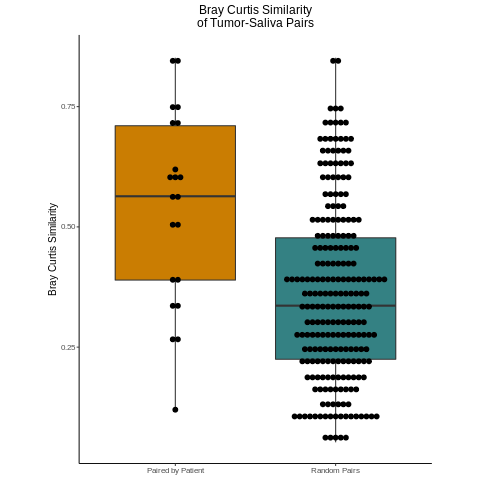

In [55]:
%%R 
# Select samples that are present in both WGS and Saliva data, and who have sufficient
# total # bacterial reads - lets do a cutoff a 10,000
#-----------------------------------------------------------------------------------------#

# First, will isolate only shared samples
wgs_tumor_shared_colnames <- colnames(wgs_tumor)[colnames(wgs_tumor) %in% colnames(wgs_saliva)]
shared_sample_list <- wgs_tumor_shared_colnames[10:length(wgs_tumor_shared_colnames)]

# Find the samples that have greater than <threshold> # of bacterial reads in both tumor + saliva=
get_samples_that_pass_bacterial_superkingdom_threshold <- function(in_tbl, sample_list, threshold){
  # Takes in an input tibble, which should have the kingdom and type columns still. Also takes in 
  # a sample_list, which is a vector that helps the funciton know which columns contain actual sample
  # information and not, i.e. mean/taxonomy inforrmation. Threshold is the required number of 
  # bacterial superkingdom reads. A vector of sample names that meets this threshold is output.
  
  tmp <- in_tbl %>%
    filter(kingdom=="Bacteria", type=="superkingdom") %>%
    select(sample_list) %>%
    t() %>%
    as.data.frame()
  
  tmp$sample <- rownames(tmp)
  meets_threshold <- as.tibble(tmp) %>%
    filter(V1 >threshold) %>%
    pull(sample)
  
  meets_threshold
}

# Get samples that pass threshold
saliva_meets_threshold <- get_samples_that_pass_bacterial_superkingdom_threshold(wgs_saliva, shared_sample_list, 10000)
tumor_meets_threshold <- get_samples_that_pass_bacterial_superkingdom_threshold(wgs_tumor, shared_sample_list, 10000)

# Get samples that are in both saliva and tumor
meet_threshold_and_shared <- intersect(saliva_meets_threshold, tumor_meets_threshold)
to_keep <- c(colnames(wgs_saliva)[1:9], meet_threshold_and_shared)

# Make new dataframes with just those passing samples
saliva_4_bray <- wgs_saliva %>%
  select(to_keep)
tumor_4_bray <- wgs_tumor %>%
  select(to_keep)

# Sort for bacterial genera
saliva_4_bray <- extract_data(saliva_4_bray, "Bacteria", "genus", info_cols)
tumor_4_bray <- extract_data(tumor_4_bray, "Bacteria", "genus", info_cols)

# Convert to relative abundance
saliva_4_bray <- relative_abundance(saliva_4_bray)
tumor_4_bray <- relative_abundance(tumor_4_bray)

# Make a copy that will remain tibbles
saliva_4_bray_tbl <- saliva_4_bray
tumor_4_bray_tbl <- tumor_4_bray

# Convert to formatted dataframe where the genus names are rownames
saliva_4_bray <- name_col_to_rownames(saliva_4_bray)
tumor_4_bray <- name_col_to_rownames(tumor_4_bray)

# Label the colnames based on their origin
colnames(saliva_4_bray) <- paste(colnames(saliva_4_bray), "_saliva", sep="")
colnames(tumor_4_bray) <- paste(colnames(tumor_4_bray), "_tumor", sep="")


# Bray curtis between paired samples
#-------------------------------------------------------#

get_bray_similiarity <- function(vector1, vector2){
  
  # Join the vectors
  joined_vectors <- data.frame(vector1, vector2)
  
  # Vegdist gives DISSIMILARITY, so need to subtract from 1 to get similarity
  1 - vegdist(t(joined_vectors))[1]
}

# Iterate through each sample and get the paired bray curtis distances
bray_paired <- tibble(sample_name = character(), bray_curtis = numeric())
colnames(bray_paired) <- c("sample_name", "bray_curtis")

for (sample_name in meet_threshold_and_shared) {
  
  # First, extract the vectors
  tumor_name <- paste(sample_name, "_tumor", sep="")
  saliva_name <- paste(sample_name, "_saliva", sep="")
  
  tumor_vector <- tumor_4_bray %>% 
    select(tumor_name) %>%
    pull(tumor_name)
  
  saliva_vector <- saliva_4_bray %>% 
    select(saliva_name) %>%
    pull(saliva_name)
  
  bray <- get_bray_similiarity(tumor_vector, saliva_vector)
  bray_paired <- add_row(bray_paired, sample_name = sample_name, bray_curtis = bray)
}

# Bray curtis between random samples
#-------------------------------------------------------#

# Make recepticle for the bray similarity
bray_random <-  NULL

# Make list of comparisons that have already been done
comparisons_done <- NULL

for (sample_name1 in meet_threshold_and_shared) {
  for (sample_name2 in meet_threshold_and_shared) {
    
    # Check if the comparison has already been done
    comparison1 = paste(sample_name1, sample_name2, sep=" ")
    comparison2 = paste(sample_name2, sample_name1, sep=" ")
    
    if (comparison1 %in% comparisons_done) {
      next
    }
    
    if (comparison2 %in% comparisons_done) {
      next
    }

    # First, extract the vectors
    tumor_name <- paste(sample_name1, "_tumor", sep="")
    saliva_name <- paste(sample_name2, "_saliva", sep="")
    
    tumor_vector <- tumor_4_bray %>% 
      select(tumor_name) %>%
      pull(tumor_name)
    
    saliva_vector <- saliva_4_bray %>% 
      select(saliva_name) %>%
      pull(saliva_name)
    
    bray <- get_bray_similiarity(tumor_vector, saliva_vector)
    bray_random <- append(bray_random, bray)
    
    # Add to comparision done
    comparisons_done <- append(comparisons_done, comparison1)
    comparisons_done <- append(comparisons_done, comparison2)

  }
}

bray_random <- as.tibble(bray_random)


# Plotting both the sample-paired and randomly-paired bray indexes
#-----------------------------------------------------------------------------------------#
bray_paired$type = "Paired by Patient"
bray_random$sample_name = "NA"
bray_random$type = "Random Pairs"
colnames(bray_random)[1] <- "bray_curtis"

bray_paired_and_random_combined <- bind_rows(bray_paired, bray_random)

bray_paired_vs_random_jaccard_distances_plot <- ggplot(data=bray_paired_and_random_combined, aes(x=type, y=bray_curtis)) +
  geom_boxplot(aes(fill=type)) +
  geom_dotplot(binaxis='y', stackdir='center', dotsize=0.4, position = position_dodge(1)) +
  theme_classic(base_size = 10) +
  ylab("Bray Curtis Similarity") +
  theme(axis.title.x=element_blank(),
        plot.title = element_text(hjust = 0.5),
        legend.position="none") +
  coord_fixed(ratio = 3) +
  ggtitle("Bray Curtis Similarity\nof Tumor-Saliva Pairs") +
  scale_fill_manual(values=c("#CA7D02", "#348183"))

# t-test between the two
#-----------------------------------------------------------------------------------------#
t.test(bray_paired$bray_curtis, bray_random$bray_curtis)

wilcox.test(bray_paired$bray_curtis, bray_random$bray_curtis)

# Plot
bray_paired_vs_random_jaccard_distances_plot


## Check correlations between tumor and oral bacterial genera in each pt.

R[write to console]: Using name as id variables

R[write to console]: Using name as id variables



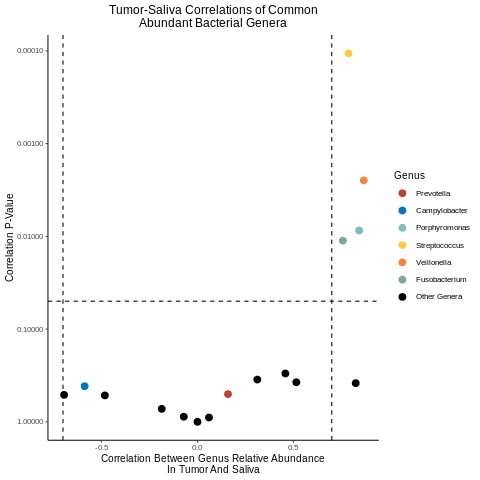

In [56]:
%%R

# Check coorelations between tumor and oral bacterial genera in each pt.
genera_set_1 <- c("Veillonella", "Porphyromonas", "Streptococcus", "Fusobacterium")
genera_set_2 <- c("Selenomonas", "Prevotella", "Campylobacter", "Porphyromonas", "Streptococcus","Veillonella", "Fusobacterium")


tumor_4_bray$name <- rownames(tumor_4_bray)
tumor_4_bray <- as_tibble(tumor_4_bray) %>%
  select(name, everything())
saliva_4_bray$name <- rownames(saliva_4_bray)
saliva_4_bray <- as_tibble(saliva_4_bray) %>%
  select(name, everything())

# Function to specify a bug, and determine the corr between tumor and saliva abundance
find_corr <- function(tbl1, tbl2, name) {
  tbl1 <- tumor_4_bray
  tbl2 <- saliva_4_bray
  specified_name <- "Campylobacter"
  
  vector1 <- tbl1 %>%
    filter(name == specified_name) %>%
    slice() %>%
    unlist(., use.names=F) %>%
    tail(length(.)-1) %>%
    as.numeric()
  
  vector2 <- tbl2 %>%
    filter(name == specified_name) %>%
    slice() %>%
    unlist(., use.names=F) %>%
    tail(length(.)-1) %>%
    as.numeric()
  
  
  test <- cor.test(vector1, vector2)
  
  test
  
  # return:
  # as.numeric(test$statistic)
  # test$p.value
  
}



# Instead, lets find corr between all bugs
tumor_4_bray.m <- tumor_4_bray %>%
  melt() %>%
  filter(name != "Ileibacterium")%>%
  filter(value > 0.01)
tumor_4_bray.m$variable <- str_replace_all(tumor_4_bray.m$variable, "_tumor", "")

saliva_4_bray.m <- saliva_4_bray %>%
  melt() %>%
  filter(name != "Ileibacterium") %>%
  filter(value > 0.01)
saliva_4_bray.m$variable <- str_replace_all(saliva_4_bray.m$variable, "_saliva", "")


genus_list <- saliva_4_bray.m$name[saliva_4_bray.m$name %in% tumor_4_bray.m$name] %>% unique()


out_tibble <- tibble(name = c(""), corr = as.numeric(c("")), p =  as.numeric(c("")))
for (genus in genus_list) {
  
  
  # First determine shared list of samples where the specified genus is present
  # in both tumor and saliva
  saliva_names_with_genus <- saliva_4_bray.m %>%
    filter(name == genus) %>%
    pull(variable) %>%
    as.character()
  
  tumor_names_with_genus <- tumor_4_bray.m %>%
    filter(name == genus) %>%
    pull(variable) %>%
    as.character()
  
  sample_genus_in_both <- saliva_names_with_genus[saliva_names_with_genus %in% tumor_names_with_genus]
  
  tumor_vector <- tumor_4_bray.m %>%
    filter(variable %in% sample_genus_in_both,
           name == get("genus")) %>%
    pull(value)
  
  saliva_vector <- saliva_4_bray.m %>%
    filter(variable %in% sample_genus_in_both,
           name == get("genus")) %>%
    pull(value) 
  
  if (length(unique(tumor_vector)) < 3) {
    correlation = NA
    p = NA
  } else if (length(unique(saliva_vector)) < 3 ) {
    correlation = NA
    p = NA
  } else {
    t <- cor.test(tumor_vector, saliva_vector)
    correlation <- as.numeric(t$estimate, method="pearson")
    p <- t$p.value
  }
  
  out_tibble <- out_tibble %>%
    add_row(name = get("genus"),
            corr = correlation,
            p = p)
}



# Label generas that are significantly correlated
out_tibble <- out_tibble %>%
  mutate(Genus = ifelse(
    name %in% genera_set_2,
    name,
    "Other Genera"
  )) ############### instead, need to label generas that are also present in the next paired stacked barplots ##############################################################################################################################

# Order the generas
out_tibble$Genus <- factor(out_tibble$Genus, ordered=T, levels=c(genera_set_2, "Other Genera"))

tumor_saliva_corr_plt <- out_tibble %>% filter(corr != "NA") %>%
  ggplot() +
  geom_point(
    aes(
      x = corr,
      y = p,
      color=Genus
    ),
    size=3
  ) +
  theme_classic(base_size=10) +
  scale_y_continuous(trans = trans_reverser('log10'), labels=comma) + # Other option is trans="reverse"...
  scale_color_manual(values=c("#BB4430", "#0077b6", "#7EBDC2", "#FDCA40", "#EE8844", "#7DAA92", "#000000")) +
  ylab("Correlation P-Value") +
  xlab("Correlation Between Genus Relative Abundance\nIn Tumor And Saliva") +
  geom_hline(yintercept = 0.05, linetype="dashed") +
  geom_vline(xintercept=c(-.7, .7), linetype="dashed") +
  ggtitle("Tumor-Saliva Correlations of Common\nAbundant Bacterial Genera") +
  theme(plot.title = element_text(hjust = 0.5))
tumor_saliva_corr_plt

## Plotting paired microbiomes

Joining, by = "name"


R[write to console]: Using name as id variables



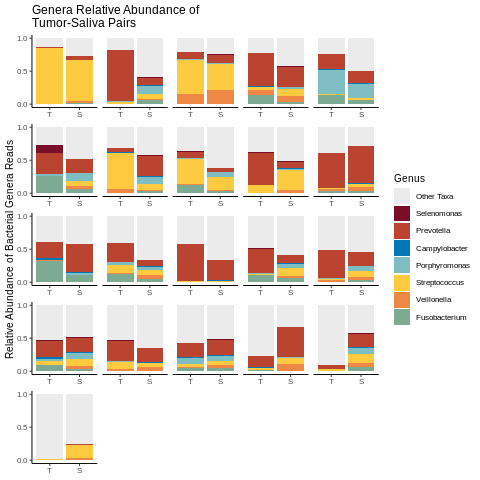

In [58]:
%%R
# MERGING
tumor_saliva_merged <- tumor_4_bray %>%
  full_join(saliva_4_bray)

# Extract
tumor_saliva_merged_extracted <- tumor_saliva_merged %>%
  isolate_taxa(genera_set_2)

# Melt and label
tumor_saliva_merged_extracted.m <- tumor_saliva_merged_extracted %>%
  melt() %>%
  mutate(tissue = ifelse(grepl("tumor", variable), "T", "S")) %>%
  mutate(variable = str_replace_all(variable, "_tumor", "")) %>%
  mutate(variable = str_replace_all(variable, "_saliva", ""))


# Make factors to specify order
tumor_saliva_merged_extracted.m$tissue <- factor(tumor_saliva_merged_extracted.m$tissue, ordered=T, levels=c("T", "S"))

tumor_saliva_merged_extracted.m$name <- factor(tumor_saliva_merged_extracted.m$name, ordered=T, levels=c("Other Taxa", genera_set_2))

# Order samples by total percentage abundance of cohort in the tumor
sample_order <- tumor_saliva_merged_extracted.m %>%
  filter(name == "Other Taxa", tissue=="T") %>%
  arrange(value) %>% pull(variable)
tumor_saliva_merged_extracted.m$variable <- factor(tumor_saliva_merged_extracted.m$variable, ordered=T, levels=sample_order)

paired_bacterial_abundance_plt <- tumor_saliva_merged_extracted.m %>%
  ggplot() +
  geom_col(
    aes(
      x = tissue,
      y = value,
      fill = name
    )
  ) +
  facet_wrap(~variable, scales="free_x") +
  theme_classic(base_size = 10) +
  scale_fill_manual(values = cohort_color_code) + #grey color on the left
  theme(strip.background = element_blank(),
        strip.text.x = element_blank(),
        axis.title.x = element_blank()) +
  scale_y_continuous(breaks=c(0, 0.5, 1)) +
  ylab("Relative Abundance of Bacterial Genera Reads") +
  labs(fill = "Genus") +
  ggtitle("Genera Relative Abundance of\nTumor-Saliva Pairs")
paired_bacterial_abundance_plt

## Tumor vs saliva enrichment for the common-abundant genera

R[write to console]: Using name as id variables

R[write to console]: Using name as id variables



Joining, by = c("name", "variable")


R[write to console]: Picking joint bandwidth of 0.0203



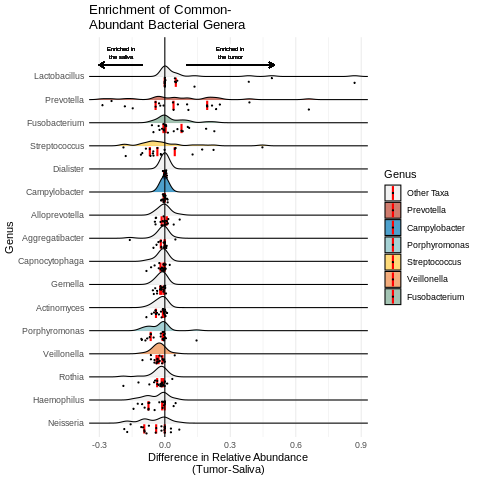

In [63]:
%%R
tumor_4_bray.m <- tumor_4_bray %>%
  melt() %>%
  mutate(variable = str_replace_all(variable, "_tumor", "")) %>%
  select(everything(), tumor=value)

saliva_4_bray.m <- saliva_4_bray %>%
  melt() %>%
  mutate(variable = str_replace_all(variable, "_saliva", "")) %>%
  select(everything(), saliva=value)

tumor_by_saliva_comparison <- 
  tumor_4_bray.m %>%
  full_join(saliva_4_bray.m)

tumor_by_saliva_comparison <- tumor_by_saliva_comparison %>%
  mutate(delta = tumor-saliva) %>%
  group_by(name) %>%
  mutate(avg_delta = mean(delta),
         median_delta = median(delta))


# # Take only names w/ average delta > 0.1 (absolute)
# tumor_by_saliva_comparison_extreme_list <- tumor_by_saliva_comparison %>%
#   select(name, median_delta, avg_delta) %>%
#   unique() %>%
#   filter(abs(avg_delta) > 0.01) %>%
#   pull(name)
# tumor_by_saliva_comparison_extremes <- tumor_by_saliva_comparison %>%
#   filter(name %in% tumor_by_saliva_comparison_extreme_list)

######################### ONLY COMMON ABUNDANT
common_abundant_genera <- out_tibble %>% 
  filter(!is.na(corr)) %>% 
  pull(name)

tumor_by_saliva_comparison_extremes <- tumor_by_saliva_comparison %>%
  filter(name %in% common_abundant_genera)
######################### ONLY COMMON ABUNDANT

# Make column for coloring
tumor_by_saliva_comparison_extremes <- tumor_by_saliva_comparison_extremes %>%
  mutate(Genus = ifelse(name %in% genera_set_2, name, "Other Taxa"))
tumor_by_saliva_comparison_extremes$Genus <- factor(tumor_by_saliva_comparison_extremes$Genus, ordered=T, levels=c("Other Taxa", genera_set_2))


# Determine naming order
tumor_by_saliva_comparison_extremes_order <- tumor_by_saliva_comparison_extremes %>%
  select(name, avg_delta) %>%
  unique() %>%
  arrange(-avg_delta) %>%
  pull(name)
tumor_by_saliva_comparison_extremes$name = factor(tumor_by_saliva_comparison_extremes$name, ordered=T, levels=rev(tumor_by_saliva_comparison_extremes_order))


tumor_by_saliva_comparison_extremes_ridge_plt <- tumor_by_saliva_comparison_extremes %>%
  ggplot() +
  geom_density_ridges(aes(x=delta, y=name, fill=Genus),
                      scale=0.7,
                      jittered_points = TRUE, quantile_lines = TRUE, alpha = 0.7,
    vline_size = 1, vline_color = "red",
    point_size = 0.4, point_alpha = 1,
    position = position_raincloud(adjust_vlines = TRUE)) +
  theme_minimal() +
  #coord_cartesian(xlim=c(-.4, .4)) +
  geom_vline(xintercept = 0) +
  ylab("Genus") +
  xlab("Difference in Relative Abundance\n(Tumor-Saliva)") +
  # geom_point(aes(y=name, x=avg_delta, fill=Genus),
  #            shape=25,
  #            position = position_nudge(y=0.5),
  #            size=3,
  #            alpha=0.2) +
  scale_fill_manual(values = cohort_color_code) + #grey color on the left
  ggtitle("Enrichment of Common-\nAbundant Bacterial Genera") +
  scale_x_continuous(expand = c(0,0))

# Adding labels
tumor_by_saliva_comparison_extremes_ridge_plt <- tumor_by_saliva_comparison_extremes_ridge_plt +
  geom_label(
    aes(label = "Enriched in\nthe tumor", x=0.3, y=17),
    label.size=0,
    fill = alpha(c("white"),0.1),
    size=2
  ) +
  coord_cartesian(ylim=c(NA, 17.1)) +
  geom_segment(
    aes(x=0.1, xend=0.5, y=16.5, yend=16.5),
    arrow = arrow(length = unit(0.2, "cm"))
  ) +
  geom_label(
    aes(label = "Enriched in\nthe saliva", x=-0.2, y=17),
    label.size=0,
    fill = alpha(c("white"),0.1),
    size=2
  ) +
  geom_segment(
    aes(x=-0.1, xend=-0.3, y=16.5, yend=16.5),
    arrow = arrow(length = unit(0.2, "cm"))
  )

tumor_by_saliva_comparison_extremes_ridge_plt

## Assemble
Note: Assembled plot doesn't render well on google collab

In [ ]:
left <- bray_paired_vs_random_jaccard_distances_plot / tumor_saliva_corr_plt + theme(legend.position="None")
middle <- tumor_by_saliva_comparison_extremes_ridge_plt + theme(legend.position="None")
assembled <- (left | middle | paired_bacterial_abundance_plt) + plot_annotation(tag_levels="A", title="Figure 3")